# Análisis GPU: Métodos de Distribuciones Estacionarias

Implementación GPU de ambos métodos para cálculo de distribuciones estacionarias en cadenas de Markov.

**Métodos**:
- **Método 1**: Vectores propios (πP = π)
- **Método 2**: Tiempo medio de retorno (πᵢ = 1/E[Tᵢ])

In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname('__file__'), '..'))

from src.markov_matrix import (
    crear_matriz_probabilidad,
    calcular_distribucion_metodo_autovalores_gpu,
    calcular_distribucion_metodo_tiempo_retorno_gpu,
    GPU_AVAILABLE,
    get_gpu_info,
    clear_gpu_memory
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

if not GPU_AVAILABLE:
    raise RuntimeError("GPU requerida pero no disponible")

gpu_info = get_gpu_info()
print(f"GPU: {gpu_info['name']} ({gpu_info['total_memory_mb']} MB)")
print(f"Compute Capability: {gpu_info['compute_capability']}")

clear_gpu_memory()

GPU: NVIDIA GeForce RTX 5060 Laptop GPU (8150 MB)
Compute Capability: 12.0


True

## Configuración del Análisis

In [2]:
max_n = 200
grid_n = np.arange(1, max_n)
grid_p = np.arange(0.1, 1, 0.1)

total_combinaciones = len(grid_n) * len(grid_p)

print(f"Configuración: n=[1-{max_n-1}], p=[0.1-0.9]")
print(f"Total: {len(grid_n)} × {len(grid_p)} = {total_combinaciones:,} combinaciones por método")
print(f"Tiempo estimado: ~{(total_combinaciones / 1000) * 2:.0f} minutos (2 métodos)")

Configuración: n=[1-199], p=[0.1-0.9]
Total: 199 × 9 = 1,791 combinaciones por método
Tiempo estimado: ~4 minutos (2 métodos)


## Ejecución del Análisis GPU

## Guardar Resultados

In [3]:
matriz_tiempos_metodo1 = np.zeros((len(grid_p), len(grid_n)))
matriz_tiempos_metodo2 = np.zeros((len(grid_p), len(grid_n)))

print(f"Iniciando análisis GPU: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

start_time_total = time.time()

print("="*60)
print("MÉTODO 1: Vectores propios GPU")
print("="*60)

start_time_m1 = time.time()
combinacion_actual = 0

for i, p in enumerate(grid_p):
    for j, n in enumerate(grid_n):
        combinacion_actual += 1
        
        if combinacion_actual % 1000 == 0:
            progreso = (combinacion_actual / total_combinaciones) * 100
            tiempo_transcurrido = time.time() - start_time_m1
            tiempo_estimado = (tiempo_transcurrido / combinacion_actual) * (total_combinaciones - combinacion_actual)
            print(f"[{progreso:5.1f}%] n={n:3d} | Transcurrido: {tiempo_transcurrido/60:.1f}min | ETA: {tiempo_estimado/60:.1f}min")
        
        try:
            matriz = crear_matriz_probabilidad(n, p)
            start_gpu = time.time()
            pi = calcular_distribucion_metodo_autovalores_gpu(matriz)
            matriz_tiempos_metodo1[i, j] = time.time() - start_gpu
        except Exception as e:
            matriz_tiempos_metodo1[i, j] = np.nan
        
        if combinacion_actual % 100 == 0:
            clear_gpu_memory()

tiempo_metodo1 = time.time() - start_time_m1
print(f"\nMétodo 1 completado: {tiempo_metodo1/60:.1f} minutos\n")

print("="*60)
print("MÉTODO 2: Tiempo medio de retorno GPU")
print("="*60)

start_time_m2 = time.time()
combinacion_actual = 0

for i, p in enumerate(grid_p):
    for j, n in enumerate(grid_n):
        combinacion_actual += 1
        
        if combinacion_actual % 1000 == 0:
            progreso = (combinacion_actual / total_combinaciones) * 100
            tiempo_transcurrido = time.time() - start_time_m2
            tiempo_estimado = (tiempo_transcurrido / combinacion_actual) * (total_combinaciones - combinacion_actual)
            print(f"[{progreso:5.1f}%] n={n:3d} | Transcurrido: {tiempo_transcurrido/60:.1f}min | ETA: {tiempo_estimado/60:.1f}min")
        
        try:
            matriz = crear_matriz_probabilidad(n, p)
            start_gpu = time.time()
            pi = calcular_distribucion_metodo_tiempo_retorno_gpu(matriz)
            matriz_tiempos_metodo2[i, j] = time.time() - start_gpu
        except Exception as e:
            matriz_tiempos_metodo2[i, j] = np.nan
        
        if combinacion_actual % 100 == 0:
            clear_gpu_memory()

tiempo_metodo2 = time.time() - start_time_m2
tiempo_total = time.time() - start_time_total

print(f"\nMétodo 2 completado: {tiempo_metodo2/60:.1f} minutos")
print(f"Tiempo total: {tiempo_total/60:.1f} minutos")

df_tiempos_metodo1 = pd.DataFrame(matriz_tiempos_metodo1, 
                                 index=[f'p={p:.1f}' for p in grid_p],
                                 columns=[f'n={n}' for n in grid_n])

df_tiempos_metodo2 = pd.DataFrame(matriz_tiempos_metodo2, 
                                 index=[f'p={p:.1f}' for p in grid_p],
                                 columns=[f'n={n}' for n in grid_n])

tiempos_validos_m1 = matriz_tiempos_metodo1[~np.isnan(matriz_tiempos_metodo1)]
tiempos_validos_m2 = matriz_tiempos_metodo2[~np.isnan(matriz_tiempos_metodo2)]

print(f"\nEstadísticas:")
print(f"Método 1 - Exitosas: {len(tiempos_validos_m1):,}/{total_combinaciones:,} ({len(tiempos_validos_m1)/total_combinaciones*100:.1f}%)")
print(f"Método 1 - Tiempo promedio: {np.mean(tiempos_validos_m1):.6f} s")
print(f"Método 2 - Exitosas: {len(tiempos_validos_m2):,}/{total_combinaciones:,} ({len(tiempos_validos_m2)/total_combinaciones*100:.1f}%)")
print(f"Método 2 - Tiempo promedio: {np.mean(tiempos_validos_m2):.6f} s")

Iniciando análisis GPU: 2025-10-02 07:33:16

MÉTODO 1: Vectores propios GPU
[ 55.8%] n=  5 | Transcurrido: 0.0min | ETA: 0.0min

Método 1 completado: 0.0 minutos

MÉTODO 2: Tiempo medio de retorno GPU
[ 55.8%] n=  5 | Transcurrido: 6.9min | ETA: 5.4min

Método 2 completado: 13.7 minutos
Tiempo total: 13.7 minutos

Estadísticas:
Método 1 - Exitosas: 1,791/1,791 (100.0%)
Método 1 - Tiempo promedio: 0.001204 s
Método 2 - Exitosas: 1,791/1,791 (100.0%)
Método 2 - Tiempo promedio: 0.458933 s


In [4]:
archivo_metodo1 = '../resultados/matriz_tiempos_gpu_metodo1.csv'
archivo_metodo2 = '../resultados/matriz_tiempos_gpu_metodo2.csv'

df_tiempos_metodo1.to_csv(archivo_metodo1)
df_tiempos_metodo2.to_csv(archivo_metodo2)

print(f"Resultados guardados:")
print(f"• Método 1: {archivo_metodo1}")
print(f"• Método 2: {archivo_metodo2}")

if len(tiempos_validos_m1) > 0 and len(tiempos_validos_m2) > 0:
    speedup = np.mean(tiempos_validos_m2) / np.mean(tiempos_validos_m1)
    print(f"\nSpeedup M1 vs M2: {speedup:.2f}x ({'M1 más rápido' if speedup > 1 else 'M2 más rápido'})")

Resultados guardados:
• Método 1: ../resultados/matriz_tiempos_gpu_metodo1.csv
• Método 2: ../resultados/matriz_tiempos_gpu_metodo2.csv

Speedup M1 vs M2: 381.29x (M1 más rápido)


## Visualización Comparativa

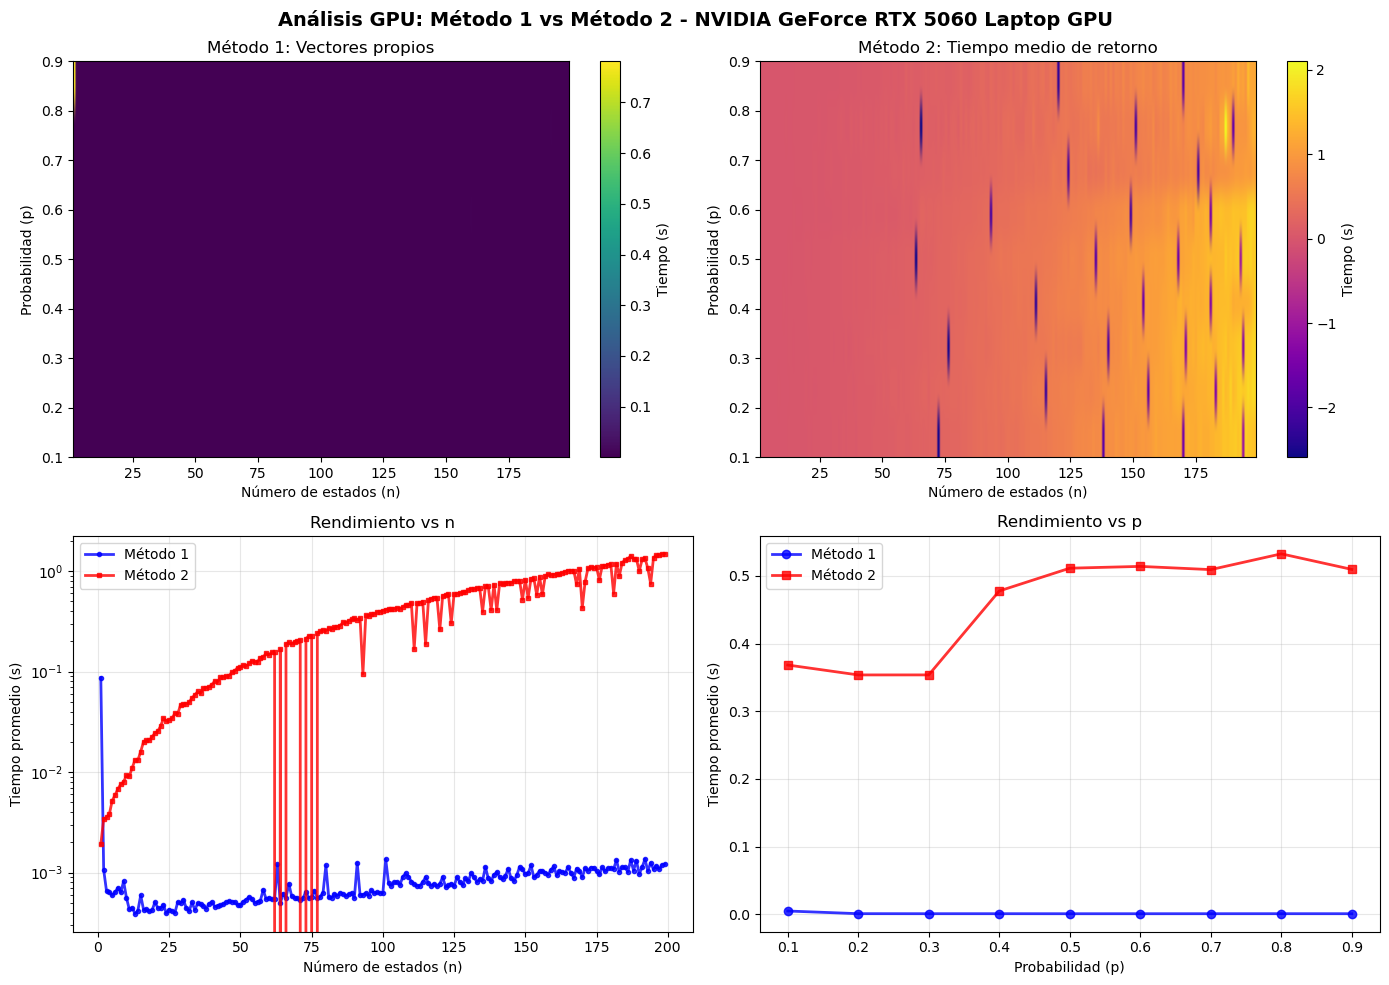

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'Análisis GPU: Método 1 vs Método 2 - {gpu_info["name"]}', fontsize=14, fontweight='bold')

matriz_viz_m1 = matriz_tiempos_metodo1.copy()
matriz_viz_m1[np.isnan(matriz_viz_m1)] = np.nanmax(matriz_viz_m1) if len(tiempos_validos_m1) > 0 else 0

matriz_viz_m2 = matriz_tiempos_metodo2.copy()
matriz_viz_m2[np.isnan(matriz_viz_m2)] = np.nanmax(matriz_viz_m2) if len(tiempos_validos_m2) > 0 else 0

im1 = axes[0,0].imshow(matriz_viz_m1, aspect='auto', cmap='viridis', 
                       extent=[grid_n[0], grid_n[-1], grid_p[0], grid_p[-1]])
axes[0,0].set_xlabel('Número de estados (n)')
axes[0,0].set_ylabel('Probabilidad (p)')
axes[0,0].set_title('Método 1: Vectores propios')
plt.colorbar(im1, ax=axes[0,0], label='Tiempo (s)')

im2 = axes[0,1].imshow(matriz_viz_m2, aspect='auto', cmap='plasma', 
                       extent=[grid_n[0], grid_n[-1], grid_p[0], grid_p[-1]])
axes[0,1].set_xlabel('Número de estados (n)')
axes[0,1].set_ylabel('Probabilidad (p)')
axes[0,1].set_title('Método 2: Tiempo medio de retorno')
plt.colorbar(im2, ax=axes[0,1], label='Tiempo (s)')

if len(tiempos_validos_m1) > 0:
    tiempos_promedio_n_m1 = np.nanmean(matriz_tiempos_metodo1, axis=0)
    indices_validos_m1 = ~np.isnan(tiempos_promedio_n_m1)
    axes[1,0].plot(grid_n[indices_validos_m1], tiempos_promedio_n_m1[indices_validos_m1], 
                   'b-o', linewidth=2, markersize=3, label='Método 1', alpha=0.8)

if len(tiempos_validos_m2) > 0:
    tiempos_promedio_n_m2 = np.nanmean(matriz_tiempos_metodo2, axis=0)
    indices_validos_m2 = ~np.isnan(tiempos_promedio_n_m2)
    axes[1,0].plot(grid_n[indices_validos_m2], tiempos_promedio_n_m2[indices_validos_m2], 
                   'r-s', linewidth=2, markersize=3, label='Método 2', alpha=0.8)

axes[1,0].set_xlabel('Número de estados (n)')
axes[1,0].set_ylabel('Tiempo promedio (s)')
axes[1,0].set_title('Rendimiento vs n')
axes[1,0].set_yscale('log')
axes[1,0].grid(True, alpha=0.3)
axes[1,0].legend()

if len(tiempos_validos_m1) > 0:
    tiempos_promedio_p_m1 = np.nanmean(matriz_tiempos_metodo1, axis=1)
    axes[1,1].plot(grid_p, tiempos_promedio_p_m1, 'b-o', linewidth=2, 
                   markersize=6, label='Método 1', alpha=0.8)

if len(tiempos_validos_m2) > 0:
    tiempos_promedio_p_m2 = np.nanmean(matriz_tiempos_metodo2, axis=1)
    axes[1,1].plot(grid_p, tiempos_promedio_p_m2, 'r-s', linewidth=2, 
                   markersize=6, label='Método 2', alpha=0.8)

axes[1,1].set_xlabel('Probabilidad (p)')
axes[1,1].set_ylabel('Tiempo promedio (s)')
axes[1,1].set_title('Rendimiento vs p')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].legend()

plt.tight_layout()
plt.show()

## Estadísticas Detalladas

In [6]:
print("="*60)
print("ANÁLISIS FINAL")
print("="*60)

print(f"\nGPU: {gpu_info['name']} ({gpu_info['total_memory_mb']} MB)")
print(f"Combinaciones procesadas: {total_combinaciones:,} × 2 métodos")
print(f"Tiempo total: {tiempo_total/60:.1f} minutos")

print("\n" + "="*60)
print("ESTADÍSTICAS POR MÉTODO")
print("="*60)

methods_data = [
    ("Método 1 - Vectores propios", matriz_tiempos_metodo1, tiempos_validos_m1, tiempo_metodo1),
    ("Método 2 - Tiempo de retorno", matriz_tiempos_metodo2, tiempos_validos_m2, tiempo_metodo2)
]

for method_name, matriz, tiempos_validos, tiempo_ejecucion in methods_data:
    print(f"\n{method_name}:")
    print(f"  Tiempo ejecución: {tiempo_ejecucion/60:.1f} min")
    print(f"  Exitosas: {len(tiempos_validos):,}/{total_combinaciones:,} ({len(tiempos_validos)/total_combinaciones*100:.1f}%)")
    
    if len(tiempos_validos) > 0:
        print(f"  Tiempo mínimo: {np.min(tiempos_validos):.6f} s")
        print(f"  Tiempo máximo: {np.max(tiempos_validos):.6f} s")
        print(f"  Tiempo promedio: {np.mean(tiempos_validos):.6f} s")
        print(f"  Mediana: {np.median(tiempos_validos):.6f} s")
        print(f"  Throughput: {len(tiempos_validos)/tiempo_ejecucion:.1f} cálculos/s")

if len(tiempos_validos_m1) > 0 and len(tiempos_validos_m2) > 0:
    print("\n" + "="*60)
    print("COMPARACIÓN")
    print("="*60)
    
    speedup = np.mean(tiempos_validos_m2) / np.mean(tiempos_validos_m1)
    throughput_m1 = len(tiempos_validos_m1) / tiempo_metodo1
    throughput_m2 = len(tiempos_validos_m2) / tiempo_metodo2
    
    print(f"\nSpeedup M1 vs M2: {speedup:.2f}x")
    print(f"Throughput M1: {throughput_m1:.1f} cálculos/s")
    print(f"Throughput M2: {throughput_m2:.1f} cálculos/s")
    print(f"Método más rápido: {'Método 1 (Vectores)' if speedup > 1 else 'Método 2 (T.Retorno)'}")

clear_gpu_memory()
print("\nMemoria GPU limpiada")

ANÁLISIS FINAL

GPU: NVIDIA GeForce RTX 5060 Laptop GPU (8150 MB)
Combinaciones procesadas: 1,791 × 2 métodos
Tiempo total: 13.7 minutos

ESTADÍSTICAS POR MÉTODO

Método 1 - Vectores propios:
  Tiempo ejecución: 0.0 min
  Exitosas: 1,791/1,791 (100.0%)
  Tiempo mínimo: 0.000292 s
  Tiempo máximo: 0.780955 s
  Tiempo promedio: 0.001204 s
  Mediana: 0.000648 s
  Throughput: 721.7 cálculos/s

Método 2 - Tiempo de retorno:
  Tiempo ejecución: 13.7 min
  Exitosas: 1,791/1,791 (100.0%)
  Tiempo mínimo: -2.589129 s
  Tiempo máximo: 2.101035 s
  Tiempo promedio: 0.458933 s
  Mediana: 0.374762 s
  Throughput: 2.2 cálculos/s

COMPARACIÓN

Speedup M1 vs M2: 381.29x
Throughput M1: 721.7 cálculos/s
Throughput M2: 2.2 cálculos/s
Método más rápido: Método 1 (Vectores)

Memoria GPU limpiada
